In [1]:
import jax, jaxlib
jax.config.update('jax_enable_x64', True)
jax.config.update('jax_platform_name', 'cpu')

from desilike.likelihoods import ObservablesGaussianLikelihood 


CUDA backend failed to initialize: Unable to load CUDA. Is it installed? (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


In [2]:


import numpy as np
import pandas as pd
import torch
from pathlib import Path

from typing import Optional, List
from torch.utils.data import TensorDataset, DataLoader
from lightning.pytorch.callbacks import ModelCheckpoint, EarlyStopping

from sunbird.emulators import FCN
import lightning as pl
from lightning import Trainer, seed_everything

from pycorr import TwoPointCorrelationFunction
import matplotlib.pyplot as plt

import scienceplots
plt.style.use('science')

In [3]:
%load_ext autoreload
%autoreload 2

In [4]:
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 300

## Load the data

Let's first load the observable we want to fit, in this case the two point correlation function directly measured on the EMC mock

In [80]:
data_dir = Path('/n/holystore01/LABS/itc_lab/Users/ccuestalazaro/sunbird/emc/')
observed_y = TwoPointCorrelationFunction.load(
    data_dir / 'data_vectors/diffsky/tpcf/z0.5/tpcf_galsampled_diffsky_mock_67120_fixedAmp_001_mass_conc_v0.3.npy'
)
observed_y = observed_y[::4](ells=(0,2),).reshape(-1)

[000131.42] [0/1] 03-20 14:36  TwoPointEstimator         INFO     Loading /n/holystore01/LABS/itc_lab/Users/ccuestalazaro/sunbird/emc/data_vectors/diffsky/tpcf/z0.5/tpcf_galsampled_diffsky_mock_67120_fixedAmp_001_mass_conc_v0.3.npy.


Now let's load the mocks used to estimate the covariance matrix

In [81]:

covariance_path = data_dir / 'covariance/tpcf/z0.5/yuan23_prior/'
n_for_covariance = 1_000
covariance_files = list(covariance_path.glob('*.npy'))[:n_for_covariance]


print(f'Reading {len(covariance_files)} covariance files')
covariance_y = [
    TwoPointCorrelationFunction.load(file)[::4](ells=(0,2),).reshape(-1) for file in covariance_files
]


Reading 1000 covariance files
[000131.69] [0/1] 03-20 14:36  TwoPointEstimator         INFO     Loading /n/holystore01/LABS/itc_lab/Users/ccuestalazaro/sunbird/emc/covariance/tpcf/z0.5/yuan23_prior/tpcf_ph3370.npy.
[000131.70] [0/1] 03-20 14:36  TwoPointEstimator         INFO     Loading /n/holystore01/LABS/itc_lab/Users/ccuestalazaro/sunbird/emc/covariance/tpcf/z0.5/yuan23_prior/tpcf_ph3684.npy.
[000131.70] [0/1] 03-20 14:36  TwoPointEstimator         INFO     Loading /n/holystore01/LABS/itc_lab/Users/ccuestalazaro/sunbird/emc/covariance/tpcf/z0.5/yuan23_prior/tpcf_ph3253.npy.


[000131.71] [0/1] 03-20 14:36  TwoPointEstimator         INFO     Loading /n/holystore01/LABS/itc_lab/Users/ccuestalazaro/sunbird/emc/covariance/tpcf/z0.5/yuan23_prior/tpcf_ph4060.npy.
[000131.72] [0/1] 03-20 14:36  TwoPointEstimator         INFO     Loading /n/holystore01/LABS/itc_lab/Users/ccuestalazaro/sunbird/emc/covariance/tpcf/z0.5/yuan23_prior/tpcf_ph3350.npy.
[000131.72] [0/1] 03-20 14:36  TwoPointEstimator         INFO     Loading /n/holystore01/LABS/itc_lab/Users/ccuestalazaro/sunbird/emc/covariance/tpcf/z0.5/yuan23_prior/tpcf_ph3658.npy.
[000131.73] [0/1] 03-20 14:36  TwoPointEstimator         INFO     Loading /n/holystore01/LABS/itc_lab/Users/ccuestalazaro/sunbird/emc/covariance/tpcf/z0.5/yuan23_prior/tpcf_ph3435.npy.
[000131.78] [0/1] 03-20 14:36  TwoPointEstimator         INFO     Loading /n/holystore01/LABS/itc_lab/Users/ccuestalazaro/sunbird/emc/covariance/tpcf/z0.5/yuan23_prior/tpcf_ph3655.npy.
[000131.79] [0/1] 03-20 14:36  TwoPointEstimator         INFO     Loading /

In [82]:
prefactor = 1./8.
covariance_matrix = prefactor * np.cov(np.array(covariance_y).T)

correlation_matrix = np.corrcoef(np.array(covariance_y).T)

plt.imshow(correlation_matrix, origin='lower')

And now let's read in the sampled HOD parameters and the tpcfs from the training set

In [ ]:
lhc_y = np.load(data_dir / 'training_sets/tpcf/z0.5/yuan23_prior/cosmopower/tpcf.npy', allow_pickle=True,).item()
s = lhc_y['s']
lhc_y = lhc_y['multipoles']
lhc_x = pd.read_csv(data_dir / 'hod_params/yuan23/hod_params_yuan23_c000.csv')
lhc_x_names = list(lhc_x.columns)
lhc_x_names = [name.replace(' ', '').replace('#', '') for name in lhc_x_names]
lhc_x = lhc_x.values[:len(lhc_y),:]

print(lhc_x.shape, lhc_y.shape, s.shape)


# let's keep a few points for testing the model
lhc_test_y = lhc_y[:100]
lhc_test_x = lhc_x[:100]

lhc_test_y = lhc_y[100:]
lhc_test_x = lhc_x[100:]

(30000, 12) (30000, 100) (50,)


let's plot everything together to check that it makes sense

Text(0, 0.5, '$r^2 \\xi(r)$')

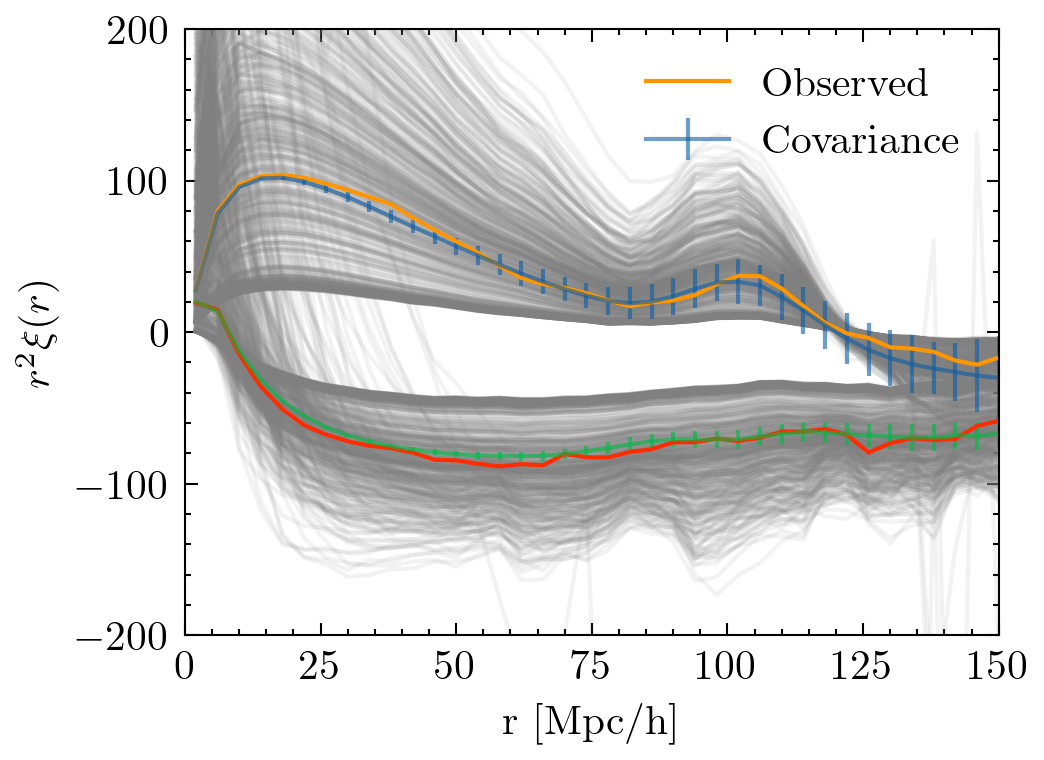

In [ ]:
for i in range(500):
    plt.plot(
        s,
        s**2*lhc_y[i,:50],
        color='gray',
        alpha=0.1,
    )
    plt.plot(
        s,
        s**2*lhc_y[i,50:],
        color='gray',
        alpha=0.1,
    )

plt.errorbar(
    s, 
    s**2*np.mean(covariance_y, axis=0)[:50], 
    yerr=s**2*np.sqrt(np.diag(covariance_matrix)[:50]),
    label='Covariance', 
    alpha=0.6,
)
plt.errorbar(
    s, 
    s**2*np.mean(covariance_y, axis=0)[50:], 
    yerr=s**2*np.sqrt(np.diag(covariance_matrix)[50:]),
    alpha=0.6,
)

plt.plot(s, s**2*observed_y[:50], label='Observed')
plt.plot(s, s**2*observed_y[50:])


plt.legend()
plt.xlim(0,150)
plt.ylim(-200,200)
plt.xlabel('r [Mpc/h]')
plt.ylabel(r'$r^2 \xi(r)$')

## Train an emulator

In [ ]:
class ArrayDataModule(pl.LightningDataModule):
    def __init__(
        self,
        x: np.array,
        y: np.array,
        val_idx: Optional[List[int]] = None,
        val_fraction: Optional[float] = None,
        input_transforms=None,
        output_transforms=None,
        batch_size: int = 256,
    ):
        super().__init__()
        x, y = torch.Tensor(x), torch.Tensor(y)
        if val_idx is not None:
            train_idx = list(set(range(len(x))) - set(val_idx))
        elif val_fraction is not None:
            # sample val_idx randomly
            val_idx = np.random.choice(
                len(x), int(val_fraction * len(x)
            ), replace=False)
            train_idx = list(set(range(len(x))) - set(val_idx))
        self.ds_train = TensorDataset(x[train_idx], y[train_idx])
        self.ds_val = TensorDataset(x[val_idx], y[val_idx])
        self.batch_size = batch_size
        self.n_input = x.shape[-1]
        self.n_output = y.shape[-1]

    def train_dataloader(self,):
        return DataLoader(
            self.ds_train,
            batch_size=self.batch_size,
            shuffle=True,
        )

    def val_dataloader(self,):
        return DataLoader(
            self.ds_val,
            batch_size=self.batch_size,
            shuffle=False,
        )

    def setup(self, stage=None):
        return 

In [ ]:
batch_size = 256
train_mean = np.mean(lhc_y, axis=0)
train_std = np.std(lhc_y, axis=0)

lhc_y_standarized = (lhc_y - train_mean) / train_std
dm = ArrayDataModule(torch.Tensor(lhc_x), torch.Tensor(lhc_y_standarized), val_fraction=0.2, batch_size=batch_size)
dm.setup()

In [ ]:
def fit(**kwargs):
    early_stop_callback = EarlyStopping(
        monitor="val_loss", patience=50, mode="min",
    )
    checkpoint_callback = ModelCheckpoint(
        monitor='val_loss',
        dirpath='my_model_checkpoints',
        filename='best-model-{epoch:02d}-{val_loss:.2f}',
        save_top_k=1,
        mode='min',
    )

    model = FCN(
        n_input=dm.n_input,
        n_output=dm.n_output,
        n_hidden=kwargs['n_hidden'],
        dropout_rate=kwargs['dropout_rate'],
        learning_rate=kwargs['learning_rate'],
        weight_decay=kwargs['weight_decay'],
        act_fn='GELU',
        loss='mse',
        load_loss=True,
        output_transforms=None,
    )

    seed_everything(42, workers=True)

    trainer = Trainer(
        accelerator="auto",
        callbacks=[early_stop_callback, checkpoint_callback],
        gradient_clip_val=0.5,
        deterministic=True,
        max_epochs=1000,
    )

    trainer.fit(
        model,
        dm,
    )
    best_val_epoch = early_stop_callback.best_score.item()
    weights_dict = torch.load(
        checkpoint_callback.best_model_path,
        map_location=torch.device("cpu"),
    )
    state_dict = weights_dict["state_dict"]
    model.load_state_dict(state_dict, strict=True)
    return best_val_epoch, model

In [ ]:
val_loss, model = fit(n_hidden=[512, 512, 512, 512,], dropout_rate=0., learning_rate=1e-3, weight_decay=0.)

[rank: 0] Seed set to 42
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name     | Type       | Params
----------------------------------------
0 | mlp      | Sequential | 845 K 
1 | loss_fct | MSELoss    | 0     
----------------------------------------
845 K     Trainable params
0         Non-trainable params
845 K     Total params
3.384     Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

In [ ]:
val_loss

0.22202657163143158

In [ ]:
val_loss

0.22202657163143158

In [ ]:
model.eval()
model = model.cpu()
with torch.no_grad():
    pred_test_y, _ = model(torch.Tensor(lhc_test_x))
pred_test_y = pred_test_y.numpy()
pred_test_y = pred_test_y * train_std + train_mean

In [ ]:
emulator_error = (pred_test_y - lhc_test_y)/np.sqrt(np.diag(covariance_matrix))
print(emulator_error.shape)
q68 = np.quantile(emulator_error, [0.16, 0.84], axis=0)
q95 = np.quantile(emulator_error, [0.025, 0.975], axis=0)
q99 = np.quantile(emulator_error, [0.005, 0.995], axis=0)

(29900, 100)


In [ ]:
print(q68.shape)

(2, 100)


<>:1: SyntaxWarning: invalid escape sequence '\%'
<>:2: SyntaxWarning: invalid escape sequence '\%'
<>:1: SyntaxWarning: invalid escape sequence '\%'
<>:2: SyntaxWarning: invalid escape sequence '\%'
/n/holystore01/LABS/itc_lab/Users/ccuestalazaro/tmp/ipykernel_2335526/1772135631.py:1: SyntaxWarning: invalid escape sequence '\%'
  plt.fill_between(list(range(len(observed_y))), q95[0], q95[1], alpha=0.5, label='95\%', color='C1')
/n/holystore01/LABS/itc_lab/Users/ccuestalazaro/tmp/ipykernel_2335526/1772135631.py:2: SyntaxWarning: invalid escape sequence '\%'
  plt.fill_between(list(range(len(observed_y))), q68[0], q68[1], alpha=0.5, label='68\%', color='C0')


(-3.0, 3.0)

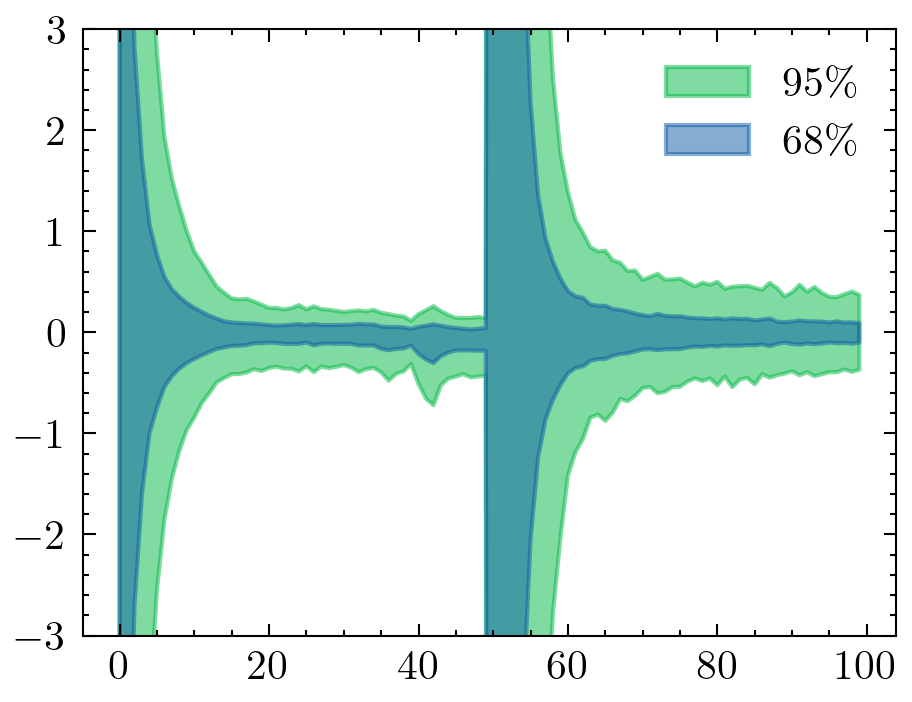

In [ ]:

plt.fill_between(list(range(len(observed_y))), q95[0], q95[1], alpha=0.5, label='95\%', color='C1')
plt.fill_between(list(range(len(observed_y))), q68[0], q68[1], alpha=0.5, label='68\%', color='C0')
plt.legend()
plt.ylim(-3,3)

Text(0, 0.5, '$r^2 \\xi(r)$')

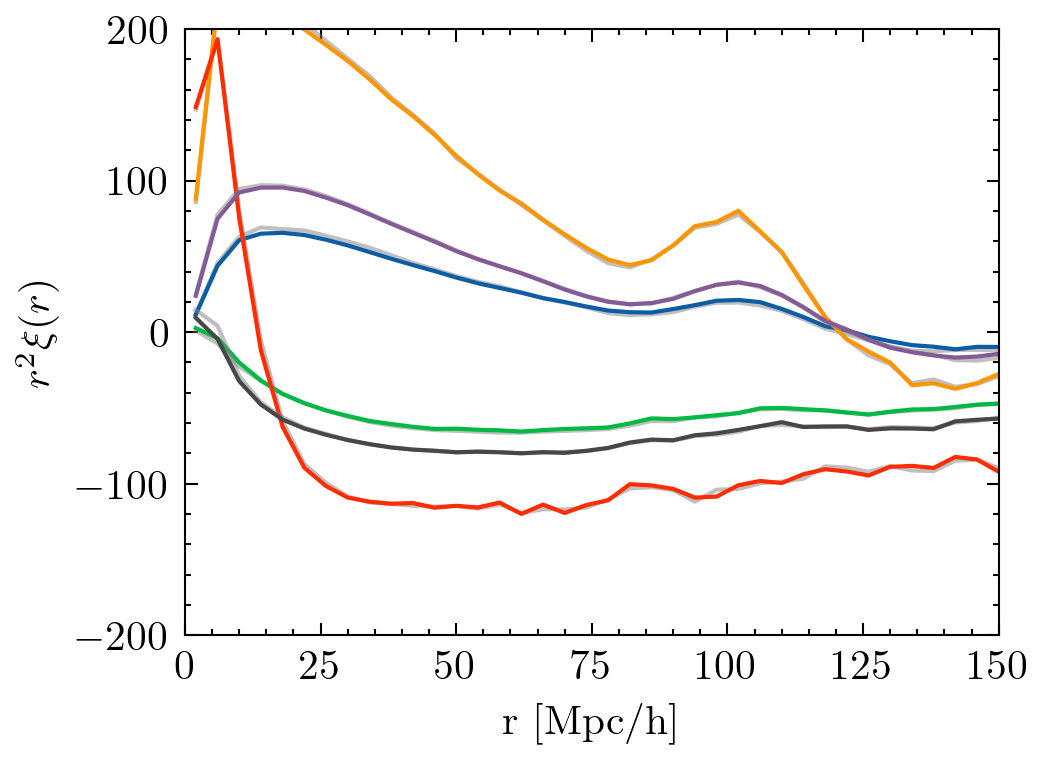

In [ ]:

for i in range(3):
    plt.plot(
        s,
        s**2*pred_test_y[i,:50],
        color='gray',
        alpha=0.5,
    )
    plt.plot(
        s,
        s**2*pred_test_y[i,50:],
        color='gray',
        alpha=0.5,
    )

    plt.plot(s, s**2*lhc_test_y[i,:50], label='Observed')
    plt.plot(s, s**2*lhc_test_y[i,50:])


plt.xlim(0,150)
plt.ylim(-200,200)
plt.xlabel('r [Mpc/h]')
plt.ylabel(r'$r^2 \xi(r)$')

In [ ]:
# optuna model
import optuna

def objective(trial, args):
    lr = trial.suggest_float(
        "learning_rate",
        1.0e-4,
        0.01,
    )
    weight_decay = trial.suggest_float("weight_decay", 1.0e-5, 0.001)
    n_layers = trial.suggest_int("n_layers", 1, 10)
    n_hidden = [
            trial.suggest_int(f"n_hidden_{layer}", 200, 1024)
            for layer in range(n_layers)
        ]
    dropout_rate = trial.suggest_float("dropout_rate", 0.0, 0.15)
    args.learning_rate = lr
    args.weight_decay = weight_decay
    args.n_hidden = n_hidden
    args.dropout_rate = dropout_rate
    return fit()

n_trials = 50
study = optuna.create_study()
optimize_objective = lambda trial: objective(trial,)
study.optimize(optimize_objective, n_trials=n_trials)



In [ ]:

# optuna topk models

## Run fast inference by taking advantage of the gradients

Note that we will ignore the emulator errors, but if sizable they should be included in the covariance

In [ ]:
# turn torch model into flax/jax so that we can use it with an HMC in desilike
nn_model, flax_params = model.to_jax()

In [ ]:
from sunbird.theory.theory import SunbirdTheoryEmulator
from desilike.base import BaseCalculator

In [ ]:
emu = SunbirdTheoryEmulator(nn_model, flax_params, lhc_x_names)

In [ ]:
class SunbirdObservable(BaseCalculator):
    def initialize(self, data, theory):
        self.data = data
        self.theory = theory

    @property
    def flatdata(self):
        return self.data

    def calculate(self, **kwargs):
        self.flattheory = self.theory.get()

In [ ]:
observable = SunbirdObservable(data=lhc_test_y[0], theory=emu)

In [ ]:
likelihood = ObservablesGaussianLikelihood(
    observables=[observable,], 
    covariance=covariance_matrix,
)

In [ ]:

loglikelihood = likelihood(logM_cut=13.5)

In [ ]:
loglikelihood

Array(-39085983.85644864, dtype=float64)

In [ ]:
print('holi')

In [ ]:
from desilike import setup_logging

setup_logging() 
likelihood.runtime_info.pipeline.calculators

In [ ]:
likelihood()

Array(-39085983.85644864, dtype=float64)

In [ ]:
from desilike.samplers import NUTSSampler

step_size = 1e-3
sampler = NUTSSampler(likelihood, seed=42,step_size=step_size)
chains = sampler.run(max_iterations=5000)

[000001.45] [0/1] 03-20 14:34  NUTSSampler               INFO     Varied parameters: ['logM_1', 'logM_cut', 'alpha', 'alpha_s', 'alpha_c', 'sigma', 'kappa', 'B_cen', 'B_sat', 'A_cen', 'A_sat', 's'].
[000008.74] [0/1] 03-20 14:34  NUTSSampler               INFO     Successfully vmap input likelihood.
[000008.92] [0/1] 03-20 14:34  NUTSSampler               INFO     Successfully jit input likelihood.
[000009.09] [0/1] 03-20 14:34  TaskManager               INFO     Entering TaskManager with 1 workers.
[000014.67] [0/1] 03-20 14:34  NUTSSampler               INFO     Using hyperparameters: {'step_size': Array(1.52123372e-05, dtype=float64, weak_type=True), 'inverse_mass_matrix': Array([9.90709198e-06, 1.13355860e-05, 9.90107366e-06, 9.91370750e-06,
       9.90118432e-06, 9.90102413e-06, 9.90104608e-06, 1.03793948e-05,
       9.91920040e-06, 9.91054794e-06, 9.90099218e-06, 9.90099029e-06],      dtype=float64)}.
[000018.40] [0/1] 03-20 14:34  TaskManager               INFO     Entering Task

In [ ]:
chains[0].shape

(5000,)

In [ ]:
#from desilike.samplers import StaticDynestySampler

#sampler = StaticDynestySampler(likelihood, save_fn='.',)
#chains = sampler.run()

In [ ]:
chain = chains[0].remove_burnin(0.5)

print(chain.to_stats(tablefmt='pretty'))

+----------+------------+------------+------------+--------+-----------------+-------------------+
|          |   argmax   |    mean    |   median   |  std   | quantile:1sigma |  interval:1sigma  |
+----------+------------+------------+------------+--------+-----------------+-------------------+
|  logM_1  |  14.28889  |  14.28869  |  14.28868  | 1.1e-4 | -1.3e-4/+1.3e-4 | -5.8e-5/+1.88e-4  |
| logM_cut |  13.3575   |  13.3608   |  13.3607   | 0.0019 | -0.0021/+0.0022 | -0.00308/+0.00100 |
|  alpha   |  0.381647  |  0.381672  |  0.381671  | 1.8e-5 | -2.0e-5/+2.1e-5 | -2.62e-5/+5.9e-6  |
| alpha_s  |  0.82924   |  0.82897   |  0.82897   | 1.6e-4 | -1.9e-4/+1.8e-4 | -8.5e-5/+2.58e-4  |
| alpha_c  |  0.289520  |  0.289556  |  0.289560  | 2.0e-5 | -2.7e-5/+2.1e-5 |  -1.2e-5/+2.9e-5  |
|  sigma   | -1.8067267 | -1.8067196 | -1.8067187 | 4.4e-6 | -4.9e-6/+4.6e-6 |  -3.9e-6/+5.2e-6  |
|  kappa   |  0.211326  |  0.211352  |  0.211354  | 1.3e-5 | -1.3e-5/+1.5e-5 |  -1.1e-5/+1.6e-5  |
|  B_cen  

In [ ]:
chain.shape

(2500,)

In [ ]:

chain_plot = chain.to_getdist()

Removed no burn in


In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline 

In [ ]:
from getdist import plots
g = plots.get_subplot_plotter()
g.settings.constrained_layout = True
g.settings.axis_marker_lw = 1.0
g.settings.axis_marker_ls = ":"
g.settings.title_limit_labels = False
g.settings.axis_marker_color = "k"
g.settings.legend_colored_text = True
g.settings.figure_legend_frame = False
g.settings.linewidth_contour = 1.0
g.settings.legend_fontsize = 22
g.settings.axes_fontsize = 16
g.settings.axes_labelsize = 20
g.settings.axis_tick_x_rotation = 45
g.settings.axis_tick_max_labels = 6

g.triangle_plot(
    roots=[chain_plot],
    #params=['logM_1', 'logM_cut', 'alpha', 'alpha_s', 'alpha_c', 'sigma'],
    filled=True,
)
plt.show()

[000070.61] [0/1] 03-20 14:35  root                      WARNING  2D kernel density bandwidth optimizer failed for logM_1, A_sat. Using fallback width: f(a) and f(b) must have different signs
[000075.47] [0/1] 03-20 14:35  root                      WARNING  2D kernel density bandwidth optimizer failed for logM_cut, A_sat. Using fallback width: f(a) and f(b) must have different signs
[000081.82] [0/1] 03-20 14:35  root                      WARNING  2D kernel density bandwidth optimizer failed for alpha_s, A_sat. Using fallback width: f(a) and f(b) must have different signs
[000089.24] [0/1] 03-20 14:35  root                      WARNING  2D kernel density bandwidth optimizer failed for sigma, kappa. Using fallback width: f(a) and f(b) must have different signs
[000094.72] [0/1] 03-20 14:35  root                      WARNING  2D kernel density bandwidth optimizer failed for B_cen, A_sat. Using fallback width: f(a) and f(b) must have different signs
[000096.25] [0/1] 03-20 14:35  root    

KeyboardInterrupt: 